# Example 1: `intrinsic` applied to VGG-16 on CIFAR-10

In this example, we apply `intrinsic` to data representations of CIFAR-10 images obtained with VGG16.

Embeddings are available at: [google drive link](https://drive.google.com/drive/folders/1mm_fYUmiOhCx8p75mHWCvemOtyCBcNO6?usp=sharing)
\
We save embeddings on layers (see the full scheme below): `features.0`, `features.5`, `features.10`, `features.19`, `features.28`, `classifier.0`, `classifier.3`, `classifier.6`.
They are saved by chunks with `chunk_size=100` at each epoch.

We calculate on each epoch for each saved layer:
*   Intrinsic dimension (by MLE, TwoNN)
*   Magnitude
*   Curvature
*   Persistence diagrams
*   Total persistence
*   Persistence entropy




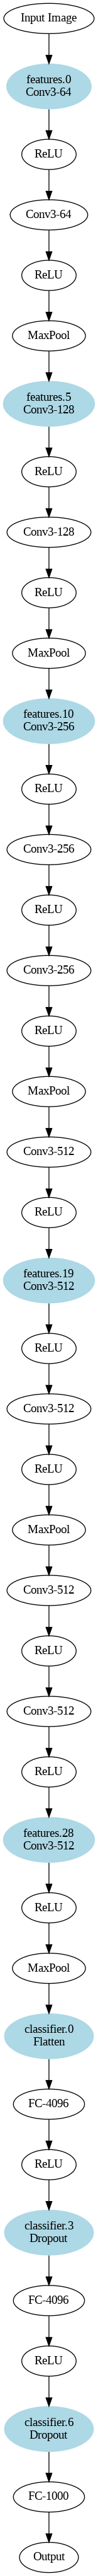

In [4]:
from IPython.display import Image
Image(filename='/content/vgg16_diagram.png')

## Imports and installs

In [ ]:
pip install giotto-ph gudhi pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.6/554.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 63.4 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from tqdm import tqdm
from torch.utils.data import Subset
import random
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Import Google Drive and mount it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare CIFAR-10

In [ ]:
# Transformations for CIFAR-10
transform = transforms.Compose(
    [transforms.Resize(224),  # VGG16 expects 224x224 images
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:12<00:00, 13389514.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Create a subset of the training set
def create_subset(dataset, subset_size):
    indices = torch.randperm(len(dataset))[:subset_size]
    subset = Subset(dataset, indices)
    return subset

In [ ]:
subset_size = 50000
train_subset = create_subset(trainset, subset_size)
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2)

## Train VGG16 model

In [ ]:
# Load VGG16 models
pretrained_model = models.vgg16(pretrained=True).to(device)
non_pretrained_model = models.vgg16(pretrained=False).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 211MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

In [ ]:
save_path = '/content/drive/My Drive/embeddings_VGG_16'
os.makedirs(save_path, exist_ok=True)

In [ ]:
# Calculate relative depth for each layer

# Load the VGG16 model
model = non_pretrained_model
layers = list(model.features) + list(model.classifier)
total_layers = len(layers)
relative_depths = [i / total_layers for i in range(total_layers)]

print("Total layers:", total_layers)
print("Relative depths:", relative_depths)

Total layers: 38
Relative depths: [0.0, 0.02631578947368421, 0.05263157894736842, 0.07894736842105263, 0.10526315789473684, 0.13157894736842105, 0.15789473684210525, 0.18421052631578946, 0.21052631578947367, 0.23684210526315788, 0.2631578947368421, 0.2894736842105263, 0.3157894736842105, 0.34210526315789475, 0.3684210526315789, 0.39473684210526316, 0.42105263157894735, 0.4473684210526316, 0.47368421052631576, 0.5, 0.5263157894736842, 0.5526315789473685, 0.5789473684210527, 0.6052631578947368, 0.631578947368421, 0.6578947368421053, 0.6842105263157895, 0.7105263157894737, 0.7368421052631579, 0.7631578947368421, 0.7894736842105263, 0.8157894736842105, 0.8421052631578947, 0.868421052631579, 0.8947368421052632, 0.9210526315789473, 0.9473684210526315, 0.9736842105263158]


In [ ]:
def get_embeddings(model, inputs, layers):
    model.eval()
    embeddings = {layer: [] for layer in layers}

    def hook(module, input, output, layer_name):
        embeddings[layer_name].append(output.cpu().detach().numpy())

    hooks = []
    for layer in layers:
        hooks.append(dict(model.named_modules())[layer].register_forward_hook(lambda m, i, o, ln=layer: hook(m, i, o, ln)))

    with torch.no_grad():
        _ = model(inputs)

    for h in hooks:
        h.remove()

    for layer in layers:
        embeddings[layer] = np.concatenate(embeddings[layer], axis=0)

    return embeddings


def save_embeddings(embeddings_accumulator, epoch, embeddings_dir='./embeddings'):
    if not os.path.exists(embeddings_dir):
        os.makedirs(embeddings_dir)

    for layer, emb_list in embeddings_accumulator.items():
        chunk_size = 1000
        num_chunks = (len(emb_list) + chunk_size - 1) // chunk_size

        for chunk_idx in range(num_chunks):
            start_idx = chunk_idx * chunk_size
            end_idx = min((chunk_idx + 1) * chunk_size, len(emb_list))

            concatenated_emb = np.concatenate(emb_list[start_idx:end_idx], axis=0).astype(np.float32)

            filename = f'{layer.replace(".", "_")}_epoch{epoch}_chunk{chunk_idx}.npy'
            np.save(os.path.join(embeddings_dir, filename), concatenated_emb)


def train_and_save_embeddings(model, trainloader, layers, num_epochs=5, save_every_batches=10000, max_embeddings=1000, embeddings_dir='./embeddings'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    if not os.path.exists(embeddings_dir):
        os.makedirs(embeddings_dir)

    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        embeddings_accumulator = {layer: [] for layer in layers}

        for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch}/{num_epochs}"), 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # print every 100 mini-batches
                print(f'[Epoch {epoch}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0


            # Save embeddings periodically
            if (i + 1) % save_every_batches == 0:
                # Accumulate embeddings for each layer
                batch_embeddings = get_embeddings(model, inputs, layers)
                for layer in layers:
                    embeddings_accumulator[layer].append(batch_embeddings[layer])
        save_embeddings(embeddings_accumulator, epoch, embeddings_dir)
        embeddings_accumulator = {layer: [] for layer in layers}  # Reset accumulator

    print('Finished Training and Saving Embeddings')

In [ ]:
# Define the layers you want to extract embeddings from
layers = ['features.0', 'features.5', 'features.10', 'features.19', 'features.28', 'classifier.0', 'classifier.3', 'classifier.6']

In [ ]:
num_epochs = 5

In [ ]:
train_and_save_embeddings(non_pretrained_model, trainloader, layers, embeddings_dir=save_path, num_epochs=num_epochs, save_every_batches=500)

Epoch 1/5:   6%|▋         | 100/1563 [00:27<06:25,  3.80it/s]

[Epoch 1, Batch 100] loss: 3.400


Epoch 1/5:  13%|█▎        | 200/1563 [00:53<06:03,  3.75it/s]

[Epoch 1, Batch 200] loss: 2.379


Epoch 1/5:  19%|█▉        | 300/1563 [01:20<05:35,  3.76it/s]

[Epoch 1, Batch 300] loss: 2.194


Epoch 1/5:  26%|██▌       | 400/1563 [01:46<05:08,  3.77it/s]

[Epoch 1, Batch 400] loss: 2.060


Epoch 1/5:  32%|███▏      | 499/1563 [02:12<04:42,  3.77it/s]

[Epoch 1, Batch 500] loss: 1.987


Epoch 1/5:  38%|███▊      | 600/1563 [02:40<04:16,  3.75it/s]

[Epoch 1, Batch 600] loss: 1.792


Epoch 1/5:  45%|████▍     | 700/1563 [03:07<03:49,  3.77it/s]

[Epoch 1, Batch 700] loss: 1.738


Epoch 1/5:  51%|█████     | 800/1563 [03:33<03:22,  3.76it/s]

[Epoch 1, Batch 800] loss: 1.707


Epoch 1/5:  58%|█████▊    | 900/1563 [04:00<02:56,  3.76it/s]

[Epoch 1, Batch 900] loss: 1.638


Epoch 1/5:  64%|██████▍   | 999/1563 [04:26<02:30,  3.76it/s]

[Epoch 1, Batch 1000] loss: 1.623


Epoch 1/5:  70%|███████   | 1100/1563 [04:54<02:03,  3.76it/s]

[Epoch 1, Batch 1100] loss: 1.590


Epoch 1/5:  77%|███████▋  | 1200/1563 [05:21<01:36,  3.76it/s]

[Epoch 1, Batch 1200] loss: 1.569


Epoch 1/5:  83%|████████▎ | 1300/1563 [05:47<01:09,  3.76it/s]

[Epoch 1, Batch 1300] loss: 1.530


Epoch 1/5:  90%|████████▉ | 1400/1563 [06:14<00:43,  3.76it/s]

[Epoch 1, Batch 1400] loss: 1.442


Epoch 1/5:  96%|█████████▌| 1499/1563 [06:40<00:17,  3.74it/s]

[Epoch 1, Batch 1500] loss: 1.453


Epoch 2/5:   6%|▋         | 100/1563 [00:26<06:32,  3.73it/s]

[Epoch 2, Batch 100] loss: 1.394


Epoch 2/5:  13%|█▎        | 200/1563 [00:53<06:01,  3.77it/s]

[Epoch 2, Batch 200] loss: 1.370


Epoch 2/5:  19%|█▉        | 300/1563 [01:20<05:34,  3.78it/s]

[Epoch 2, Batch 300] loss: 1.370


Epoch 2/5:  26%|██▌       | 400/1563 [01:46<05:10,  3.75it/s]

[Epoch 2, Batch 400] loss: 1.312


Epoch 2/5:  32%|███▏      | 499/1563 [02:13<04:43,  3.75it/s]

[Epoch 2, Batch 500] loss: 1.312


Epoch 2/5:  38%|███▊      | 600/1563 [02:40<04:16,  3.75it/s]

[Epoch 2, Batch 600] loss: 1.329


Epoch 2/5:  45%|████▍     | 700/1563 [03:07<03:49,  3.76it/s]

[Epoch 2, Batch 700] loss: 1.272


Epoch 2/5:  51%|█████     | 800/1563 [03:34<03:22,  3.76it/s]

[Epoch 2, Batch 800] loss: 1.302


Epoch 2/5:  58%|█████▊    | 900/1563 [04:00<02:56,  3.75it/s]

[Epoch 2, Batch 900] loss: 1.243


Epoch 2/5:  64%|██████▍   | 999/1563 [04:27<02:30,  3.74it/s]

[Epoch 2, Batch 1000] loss: 1.248


Epoch 2/5:  70%|███████   | 1100/1563 [04:54<02:03,  3.76it/s]

[Epoch 2, Batch 1100] loss: 1.213


Epoch 2/5:  77%|███████▋  | 1200/1563 [05:21<01:36,  3.75it/s]

[Epoch 2, Batch 1200] loss: 1.221


Epoch 2/5:  83%|████████▎ | 1300/1563 [05:48<01:09,  3.76it/s]

[Epoch 2, Batch 1300] loss: 1.154


Epoch 2/5:  90%|████████▉ | 1400/1563 [06:14<00:43,  3.76it/s]

[Epoch 2, Batch 1400] loss: 1.129


Epoch 2/5:  96%|█████████▌| 1499/1563 [06:41<00:17,  3.74it/s]

[Epoch 2, Batch 1500] loss: 1.096


Epoch 3/5:   6%|▋         | 100/1563 [00:26<06:34,  3.71it/s]

[Epoch 3, Batch 100] loss: 1.047


Epoch 3/5:  13%|█▎        | 200/1563 [00:53<06:05,  3.73it/s]

[Epoch 3, Batch 200] loss: 1.005


Epoch 3/5:  19%|█▉        | 300/1563 [01:20<05:35,  3.76it/s]

[Epoch 3, Batch 300] loss: 0.985


Epoch 3/5:  26%|██▌       | 400/1563 [01:46<05:09,  3.75it/s]

[Epoch 3, Batch 400] loss: 1.006


Epoch 3/5:  32%|███▏      | 499/1563 [02:13<04:43,  3.75it/s]

[Epoch 3, Batch 500] loss: 0.982


Epoch 3/5:  38%|███▊      | 600/1563 [02:41<04:15,  3.76it/s]

[Epoch 3, Batch 600] loss: 0.993


Epoch 3/5:  45%|████▍     | 700/1563 [03:07<03:48,  3.77it/s]

[Epoch 3, Batch 700] loss: 0.984


Epoch 3/5:  51%|█████     | 800/1563 [03:34<03:22,  3.76it/s]

[Epoch 3, Batch 800] loss: 0.947


Epoch 3/5:  58%|█████▊    | 900/1563 [04:00<02:55,  3.77it/s]

[Epoch 3, Batch 900] loss: 0.958


Epoch 3/5:  64%|██████▍   | 999/1563 [04:27<02:29,  3.77it/s]

[Epoch 3, Batch 1000] loss: 0.956


Epoch 3/5:  70%|███████   | 1100/1563 [04:54<02:03,  3.75it/s]

[Epoch 3, Batch 1100] loss: 0.896


Epoch 3/5:  77%|███████▋  | 1200/1563 [05:21<01:36,  3.77it/s]

[Epoch 3, Batch 1200] loss: 0.950


Epoch 3/5:  83%|████████▎ | 1300/1563 [05:48<01:09,  3.76it/s]

[Epoch 3, Batch 1300] loss: 0.913


Epoch 3/5:  90%|████████▉ | 1400/1563 [06:14<00:43,  3.75it/s]

[Epoch 3, Batch 1400] loss: 0.871


Epoch 3/5:  96%|█████████▌| 1499/1563 [06:41<00:17,  3.76it/s]

[Epoch 3, Batch 1500] loss: 0.892


Epoch 4/5:   6%|▋         | 100/1563 [00:26<06:30,  3.75it/s]

[Epoch 4, Batch 100] loss: 0.723


Epoch 4/5:  13%|█▎        | 200/1563 [00:53<06:02,  3.76it/s]

[Epoch 4, Batch 200] loss: 0.740


Epoch 4/5:  19%|█▉        | 300/1563 [01:19<05:35,  3.76it/s]

[Epoch 4, Batch 300] loss: 0.755


Epoch 4/5:  26%|██▌       | 400/1563 [01:46<05:09,  3.76it/s]

[Epoch 4, Batch 400] loss: 0.745


Epoch 4/5:  32%|███▏      | 499/1563 [02:12<04:43,  3.76it/s]

[Epoch 4, Batch 500] loss: 0.746


Epoch 4/5:  38%|███▊      | 600/1563 [02:40<04:16,  3.76it/s]

[Epoch 4, Batch 600] loss: 0.732


Epoch 4/5:  45%|████▍     | 700/1563 [03:07<03:49,  3.76it/s]

[Epoch 4, Batch 700] loss: 0.749


Epoch 4/5:  51%|█████     | 800/1563 [03:34<03:23,  3.75it/s]

[Epoch 4, Batch 800] loss: 0.750


Epoch 4/5:  58%|█████▊    | 900/1563 [04:00<02:56,  3.76it/s]

[Epoch 4, Batch 900] loss: 0.722


Epoch 4/5:  64%|██████▍   | 999/1563 [04:26<02:30,  3.76it/s]

[Epoch 4, Batch 1000] loss: 0.750


Epoch 4/5:  70%|███████   | 1100/1563 [04:54<02:03,  3.76it/s]

[Epoch 4, Batch 1100] loss: 0.723


Epoch 4/5:  77%|███████▋  | 1200/1563 [05:21<01:36,  3.76it/s]

[Epoch 4, Batch 1200] loss: 0.751


Epoch 4/5:  83%|████████▎ | 1300/1563 [05:48<01:09,  3.77it/s]

[Epoch 4, Batch 1300] loss: 0.697


Epoch 4/5:  90%|████████▉ | 1400/1563 [06:14<00:43,  3.75it/s]

[Epoch 4, Batch 1400] loss: 0.715


Epoch 4/5:  96%|█████████▌| 1499/1563 [06:40<00:17,  3.75it/s]

[Epoch 4, Batch 1500] loss: 0.695


Epoch 5/5:   6%|▋         | 100/1563 [00:26<06:30,  3.75it/s]

[Epoch 5, Batch 100] loss: 0.532


Epoch 5/5:  13%|█▎        | 200/1563 [00:53<06:01,  3.77it/s]

[Epoch 5, Batch 200] loss: 0.487


Epoch 5/5:  19%|█▉        | 300/1563 [01:19<05:35,  3.77it/s]

[Epoch 5, Batch 300] loss: 0.527


Epoch 5/5:  26%|██▌       | 400/1563 [01:46<05:09,  3.76it/s]

[Epoch 5, Batch 400] loss: 0.519


Epoch 5/5:  32%|███▏      | 499/1563 [02:12<04:43,  3.76it/s]

[Epoch 5, Batch 500] loss: 0.529


Epoch 5/5:  38%|███▊      | 600/1563 [02:40<04:16,  3.75it/s]

[Epoch 5, Batch 600] loss: 0.527


Epoch 5/5:  45%|████▍     | 700/1563 [03:07<03:49,  3.76it/s]

[Epoch 5, Batch 700] loss: 0.540


Epoch 5/5:  51%|█████     | 800/1563 [03:33<03:22,  3.77it/s]

[Epoch 5, Batch 800] loss: 0.554


Epoch 5/5:  58%|█████▊    | 900/1563 [04:00<02:56,  3.76it/s]

[Epoch 5, Batch 900] loss: 0.540


Epoch 5/5:  64%|██████▍   | 999/1563 [04:26<02:29,  3.77it/s]

[Epoch 5, Batch 1000] loss: 0.548


Epoch 5/5:  70%|███████   | 1100/1563 [04:54<02:02,  3.77it/s]

[Epoch 5, Batch 1100] loss: 0.560


Epoch 5/5:  77%|███████▋  | 1200/1563 [05:20<01:36,  3.75it/s]

[Epoch 5, Batch 1200] loss: 0.489


Epoch 5/5:  83%|████████▎ | 1300/1563 [05:47<01:09,  3.78it/s]

[Epoch 5, Batch 1300] loss: 0.551


Epoch 5/5:  90%|████████▉ | 1400/1563 [06:13<00:43,  3.78it/s]

[Epoch 5, Batch 1400] loss: 0.560


Epoch 5/5:  96%|█████████▌| 1499/1563 [06:40<00:16,  3.77it/s]

[Epoch 5, Batch 1500] loss: 0.549


Epoch 5/5: 100%|██████████| 1563/1563 [06:57<00:00,  3.74it/s]


Finished Training and Saving Embeddings


In [ ]:
def load_embeddings(save_path, layers, epochs):
    embeddings = {epoch: {} for epoch in epochs}
    for epoch in epochs:
        for name in layers:
            file_path = os.path.join(save_path, f'{name.replace(".", "_")}_epoch{epoch}_chunk0.npy')
            if os.path.exists(file_path):
                embeddings[epoch][name] = np.load(file_path)
            else:
                print(f"File not found: {file_path}")
    return embeddings

In [ ]:
embeddings = load_embeddings(save_path, layers[-6:], range(1, num_epochs + 1))

for epoch, embs in embeddings.items():
  for layer, emb in embs.items():
    print(f"Epoch: {epoch}, Layer: {layer}, Embedding shape: {emb.shape}")

Epoch: 1, Layer: features.10, Embedding shape: (96, 256, 56, 56)
Epoch: 1, Layer: features.19, Embedding shape: (96, 512, 28, 28)
Epoch: 1, Layer: features.28, Embedding shape: (96, 512, 14, 14)
Epoch: 1, Layer: classifier.0, Embedding shape: (96, 4096)
Epoch: 1, Layer: classifier.3, Embedding shape: (96, 4096)
Epoch: 1, Layer: classifier.6, Embedding shape: (96, 1000)
Epoch: 2, Layer: features.10, Embedding shape: (96, 256, 56, 56)
Epoch: 2, Layer: features.19, Embedding shape: (96, 512, 28, 28)
Epoch: 2, Layer: features.28, Embedding shape: (96, 512, 14, 14)
Epoch: 2, Layer: classifier.0, Embedding shape: (96, 4096)
Epoch: 2, Layer: classifier.3, Embedding shape: (96, 4096)
Epoch: 2, Layer: classifier.6, Embedding shape: (96, 1000)
Epoch: 3, Layer: features.10, Embedding shape: (96, 256, 56, 56)
Epoch: 3, Layer: features.19, Embedding shape: (96, 512, 28, 28)
Epoch: 3, Layer: features.28, Embedding shape: (96, 512, 14, 14)
Epoch: 3, Layer: classifier.0, Embedding shape: (96, 4096)
Ep

In [ ]:
list_embs = []
list_epochs = []
list_layers = []

for epoch, embs in embeddings.items():
  for layer, emb in embs.items():
    list_embs.append(emb.reshape(emb.shape[0], -1))
    list_epochs.append(epoch)
    list_layers.append(layer)

len(list_embs)

30

In [ ]:
from sklearn.preprocessing import normalize

normalized_embs = []
for emb in list_embs:
  normalized_embs.append(normalize(emb, axis=0, norm='max'))

In [ ]:
# Get relative depths of layers
vgg16 = models.vgg16()
all_layers = []

for name, layer in vgg16.named_modules():
    if isinstance(layer, (torch.nn.Conv2d, torch.nn.Linear, torch.nn.MaxPool2d, torch.nn.ReLU, torch.nn.BatchNorm2d, torch.nn.AdaptiveAvgPool2d, torch.nn.Dropout)):
        all_layers.append(name)

all_layers = list(dict.fromkeys(all_layers))

specified_layers_depths = []
for layer in layers:
    if layer in all_layers:
        specified_layers_depths.append(all_layers.index(layer) + 1)

total_layers = len(all_layers)
relative_depths = [depth / total_layers for depth in specified_layers_depths]

print("Relative Depths:", relative_depths)

Relative Depths: [0.02564102564102564, 0.15384615384615385, 0.28205128205128205, 0.5128205128205128, 0.7435897435897436, 0.8461538461538461, 0.9230769230769231, 1.0]


In [ ]:
list_relative_depths = []
for i in range(len(list_layers)):
  list_relative_depths.append(relative_depths[layers.index(list_layers[i])])

## Apply `intrinsic`

### Prepare intrinsic

In [ ]:
os.chdir('/')
if not os.path.exists("/intrinsic"):
    !git clone https://github.com/katyafilimoshina/intrinsic.git
# else:
# os.chdir("/intrinsic")
!git pull origin main

Cloning into 'intrinsic'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 64 (delta 19), reused 59 (delta 14), pack-reused 0
Receiving objects: 100% (64/64), 28.68 KiB | 117.00 KiB/s, done.
Resolving deltas: 100% (19/19), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
os.chdir('/')
# os.chdir("/intrinsic")

In [ ]:
from intrinsic.functional.magnitude import magnitude
from intrinsic.functional.dimension import two_nn, mle
from intrinsic.functional.curvature import curvature
from intrinsic.functional.homology import vr_diagrams, drop_inf, betti, euler, diagrams_barycenter, persistence_entropy, persistence_norm, total_persistence, amplitude, landscapes, wasserstein_distance, cross_barcode, r_cross_barcode, mtd, rtd, frechet_mean

In [ ]:
def plot_feature(feature, results, num_epochs, layers, list_relative_depths):
    plt.figure(figsize=(12, 8))
    for epoch in range(num_epochs):
      plt.plot(list_relative_depths[epoch * len(layers):epoch * len(layers)+len(layers)], results[epoch * len(layers):epoch * len(layers)+len(layers)], label=f'Epoch {epoch + 1}', marker='o')
    plt.xlabel('Relative depth')
    plt.ylabel(f'{feature}')
    plt.title(f'VGG-16 | CIFAR-10 | {feature} over layers on different epochs')
    plt.legend(title='Epochs')
    plt.show()

### ID

In [ ]:
def id_experiment(k=5):
  ids_mle, ids_two_nn = [], []
  for num_emb in range(len(list_embs)):
    ids_two_nn.append(two_nn(list_embs[num_emb]))
    ids_mle.append(mle(list_embs[num_emb], k).mean())
  return ids_two_nn, ids_mle

In [ ]:
ids_two_nn_vgg16, ids_mle_vgg16 = id_experiment()

In [ ]:
def plot_id(ids, num_epochs, layers, list_relative_depths):
    plt.figure(figsize=(12, 8))
    for epoch in range(num_epochs):
      plt.plot(list_relative_depths[epoch * len(layers):epoch * len(layers)+len(layers)], ids[epoch * len(layers):epoch * len(layers)+len(layers)], label=f'Epoch {epoch + 1}', marker='o')
    plt.xlabel('Relative depth')
    plt.ylabel('Intrinsic Dimension')
    plt.title(f'VGG-16 | CIFAR-10 | ID over layers on different epochs')
    plt.legend(title='Epochs')
    plt.show()

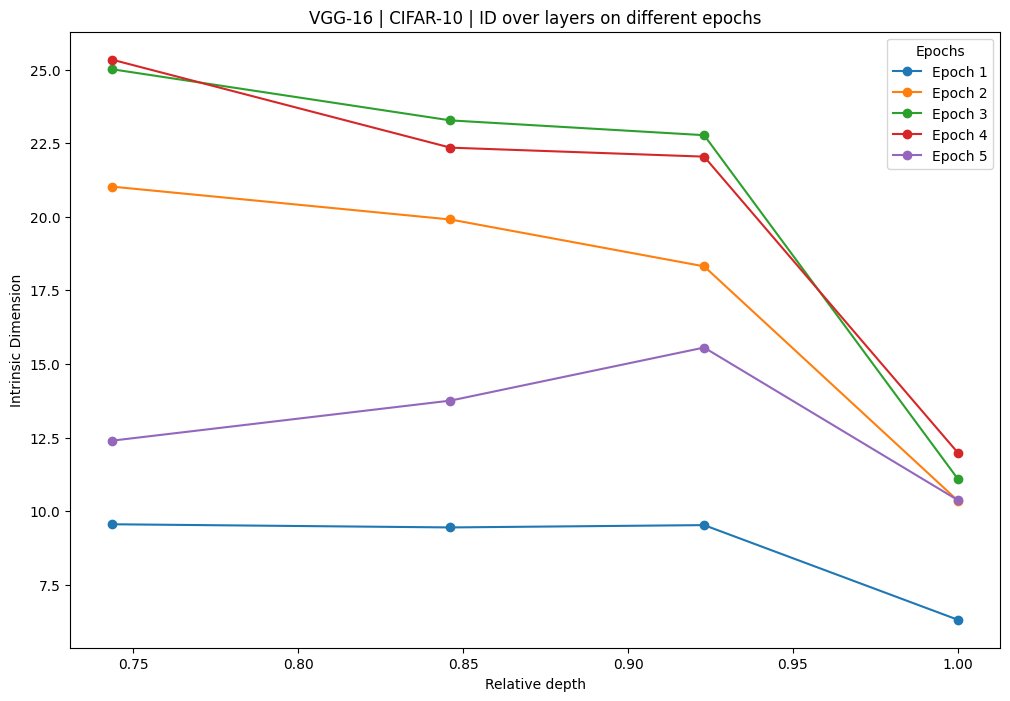

In [ ]:
plot_id(ids_two_nn_vgg16, 5, layers[-4:], list_relative_depths)

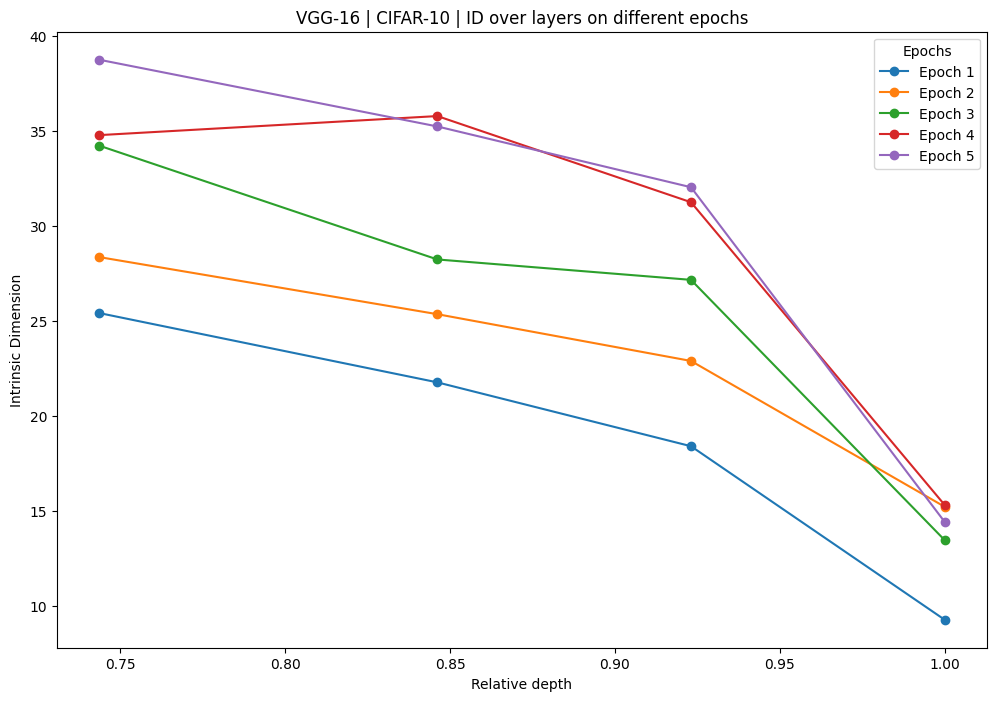

In [ ]:
plot_id(ids_mle_vgg16, 5, layers[-4:], list_relative_depths)

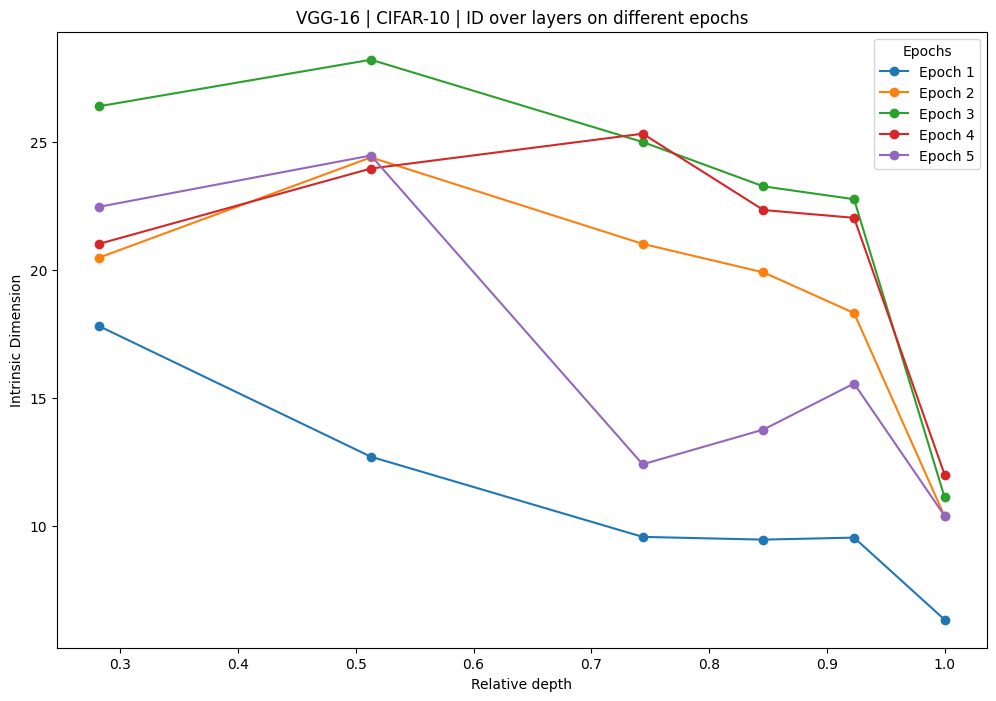

In [ ]:
plot_id(ids_two_nn_vgg16, 5, layers[-6:], list_relative_depths)

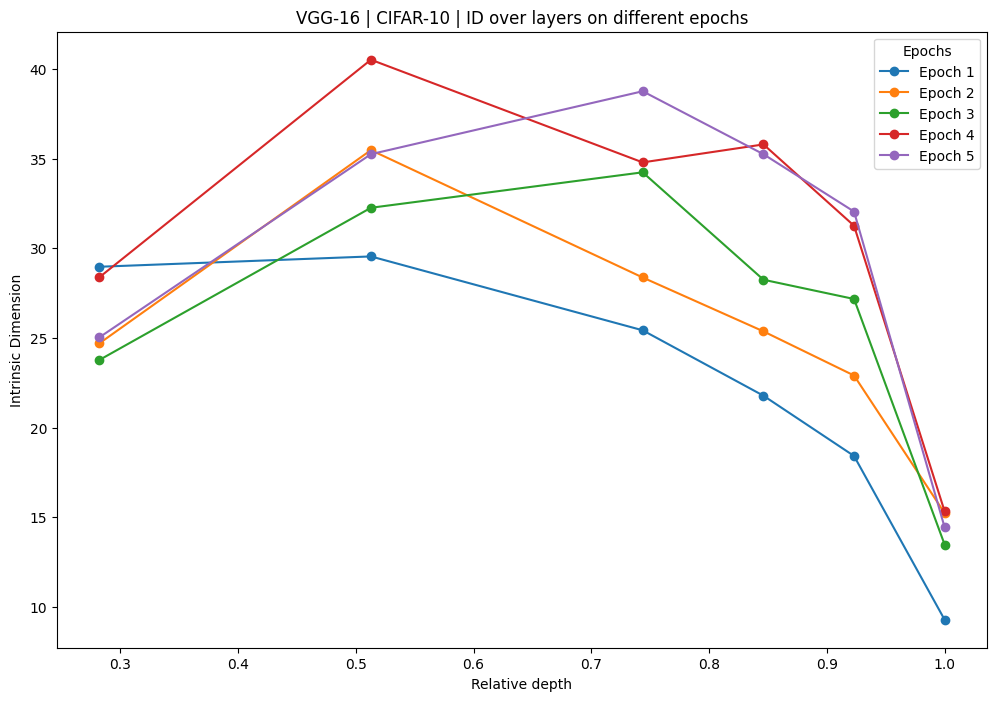

In [ ]:
plot_id(ids_mle_vgg16, 5, layers[-6:], list_relative_depths)

### Magnitude

In [ ]:
def magnitude_experiment(list_embs):
  magnitudes = []
  for num_emb in range(len(list_embs)):
    magnitudes.append(magnitude(list_embs[num_emb]))
  return magnitudes

In [ ]:
magnitudes = magnitude_experiment(normalized_embs)

In [ ]:
magnitudes

[96.0,
 96.0,
 96.0,
 95.99922995448065,
 95.79186644362753,
 82.4392975812636,
 96.0,
 96.0,
 96.0,
 96.0,
 95.99999766113083,
 94.85407365698991,
 96.0,
 96.0,
 96.0,
 96.0,
 95.99999999657538,
 95.67355188134663,
 96.0,
 96.0,
 96.0,
 96.0,
 95.99999999956144,
 95.91086639595589,
 96.0,
 96.0,
 96.0,
 96.0,
 95.99999999955747,
 95.99495799283969]

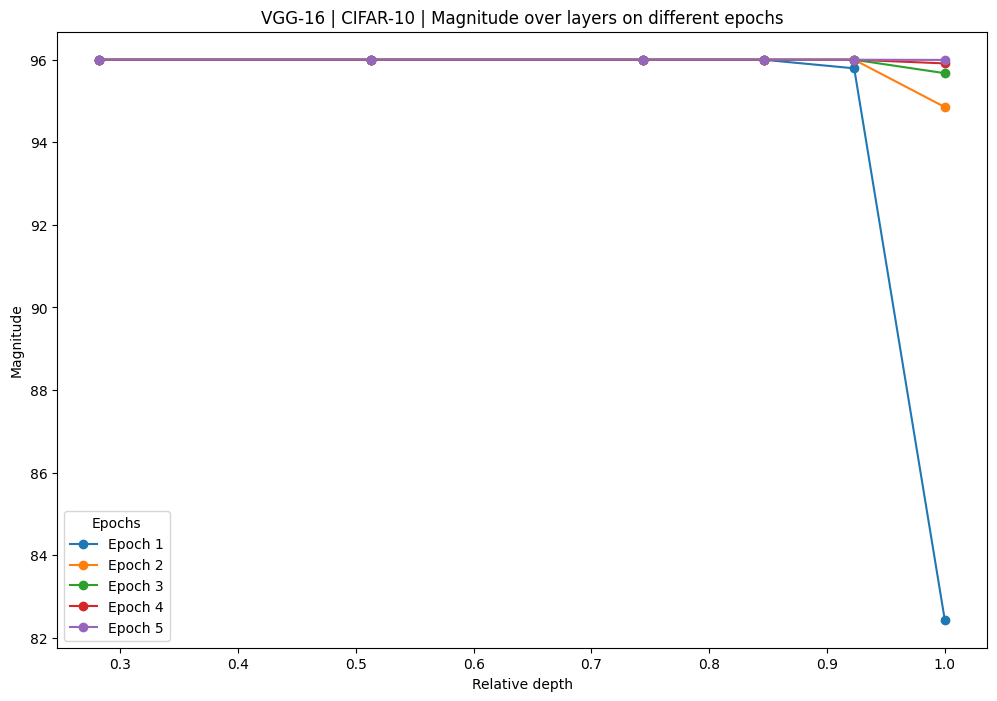

In [ ]:
plot_feature('Magnitude', magnitudes, 5, layers[-6:], list_relative_depths)

In [ ]:
def plot_feature(feature, results, num_epochs, layers, list_relative_depths):
    plt.figure(figsize=(12, 8))
    for epoch in range(2,num_epochs):
      plt.plot(list_relative_depths[epoch * len(layers):epoch * len(layers)+len(layers)], results[epoch * len(layers):epoch * len(layers)+len(layers)], label=f'Epoch {epoch + 1}', marker='o')
    plt.xlabel('Relative depth')
    plt.ylabel(f'{feature}')
    plt.title(f'VGG-16 | CIFAR-10 | {feature} over layers on different epochs')
    plt.legend(title='Epochs')
    plt.show()

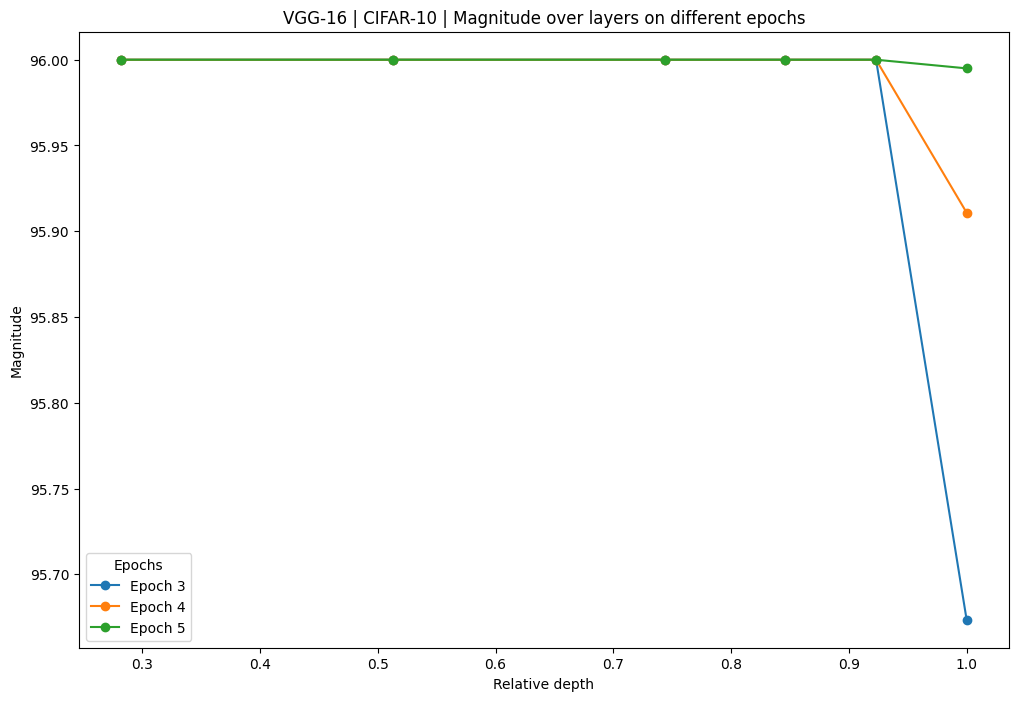

In [ ]:
plot_feature('Magnitude', magnitudes, 5, layers[-6:], list_relative_depths)

### Curvature

In [ ]:
def curvature_experiment(list_embs, k=3):
  curvatures = []
  for num_emb in range(len(list_embs)):
    curvatures.append(np.ma.masked_invalid(curvature(list_embs[num_emb], k)).mean())
  return curvatures

In [ ]:
curvatures = curvature_experiment(normalized_embs)

In [ ]:
curvatures

[masked,
 masked,
 -1.0531557942878041e+266,
 -2.4300831341051155e+136,
 -1.6528986037808117e+112,
 -4590095621042272.0,
 masked,
 masked,
 masked,
 -5.183359736490712e+144,
 -1.1174545038228793e+131,
 -2.7905527212133374e+20,
 masked,
 masked,
 masked,
 -1.6832723644120752e+132,
 -1.5498368016036123e+123,
 -2.633130540504003e+16,
 masked,
 masked,
 masked,
 -1.8695131022634515e+161,
 -1.2252329255446969e+154,
 -3.8013312670756683e+23,
 masked,
 masked,
 masked,
 -1.4256895753541072e+103,
 -7.777895235409942e+113,
 -9.339527235092607e+20]

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)


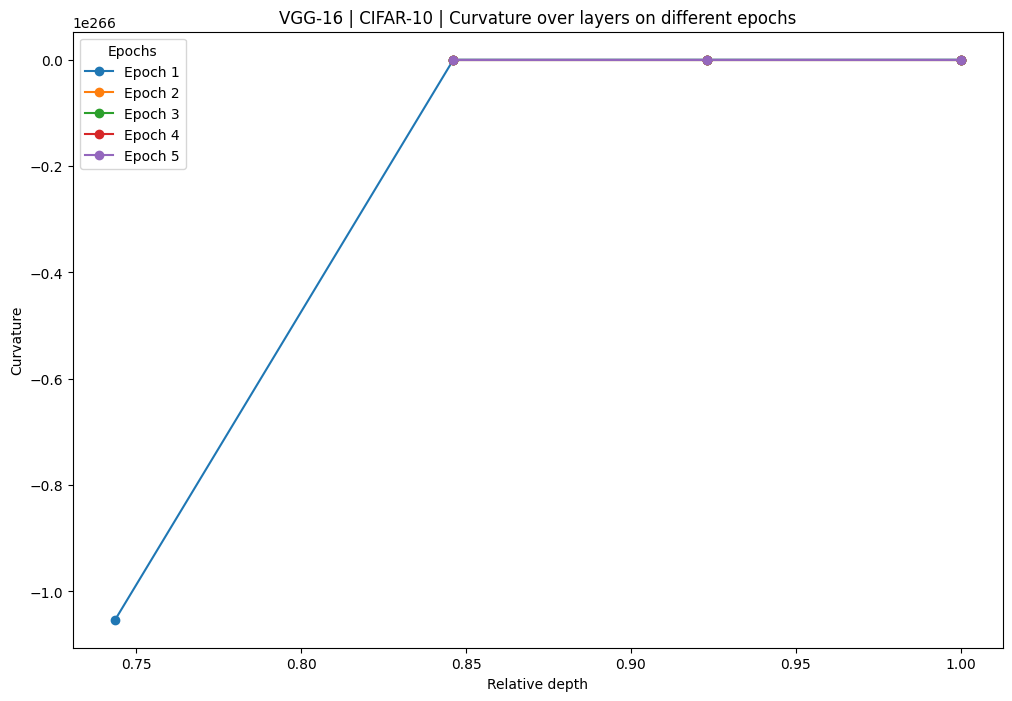

In [ ]:
plot_feature('Curvature', curvatures, 5, layers[-6:], list_relative_depths)

### Persistence diagrams

In [ ]:
pip install persim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18101 sha256=475d341813d5d4db30086cb1e44664189517ac1bf0db3db0567c303ee9d3efd0
  Stored in directory: /root/.cache/pip/wheels/ef/0f/3b/0f931844eecc34addd90e72d54cd39c08b7066c5f25c00b9a4
Successfully built hopcroftkarp


In [ ]:
from intrinsic.utils.tensorboard import plot_persistence, draw_heatmap, plot_betti, plot_andrews

In [ ]:
import persim

In [ ]:
def get_vr_diagrams(list_embs):
  vrs = []
  for i in range(len(list_embs)):
    vrs.append(drop_inf(vr_diagrams(list_embs[i])))
  return vrs

In [ ]:
vrs = get_vr_diagrams(normalized_embs)

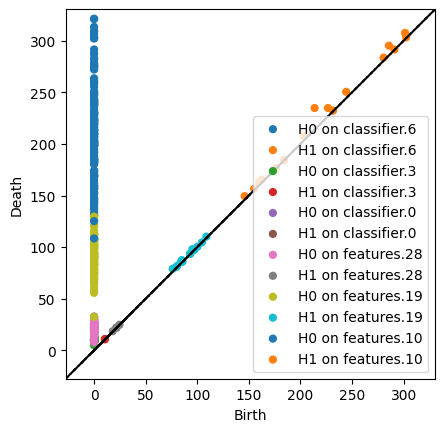

In [ ]:
for i in range(6):
  persim.plot_diagrams(vrs[-i], labels=[f'H0 on {layers[-i-1]}', f'H1 on {layers[-i-1]}'], size=35)

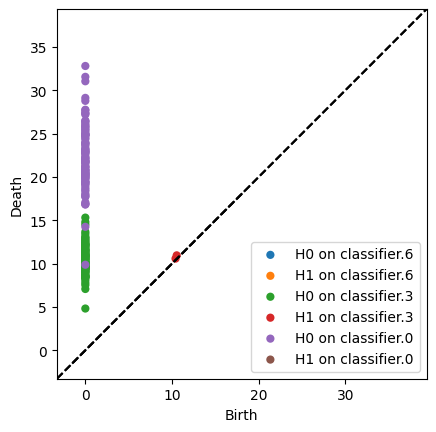

In [ ]:
for i in range(3):
  persim.plot_diagrams(vrs[-i], labels=[f'H0 on {layers[-i-1]}', f'H1 on {layers[-i-1]}'], size=35)

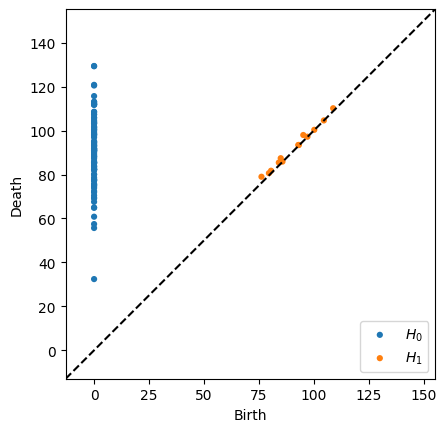

In [ ]:
persim.plot_diagrams(vrs[-4])

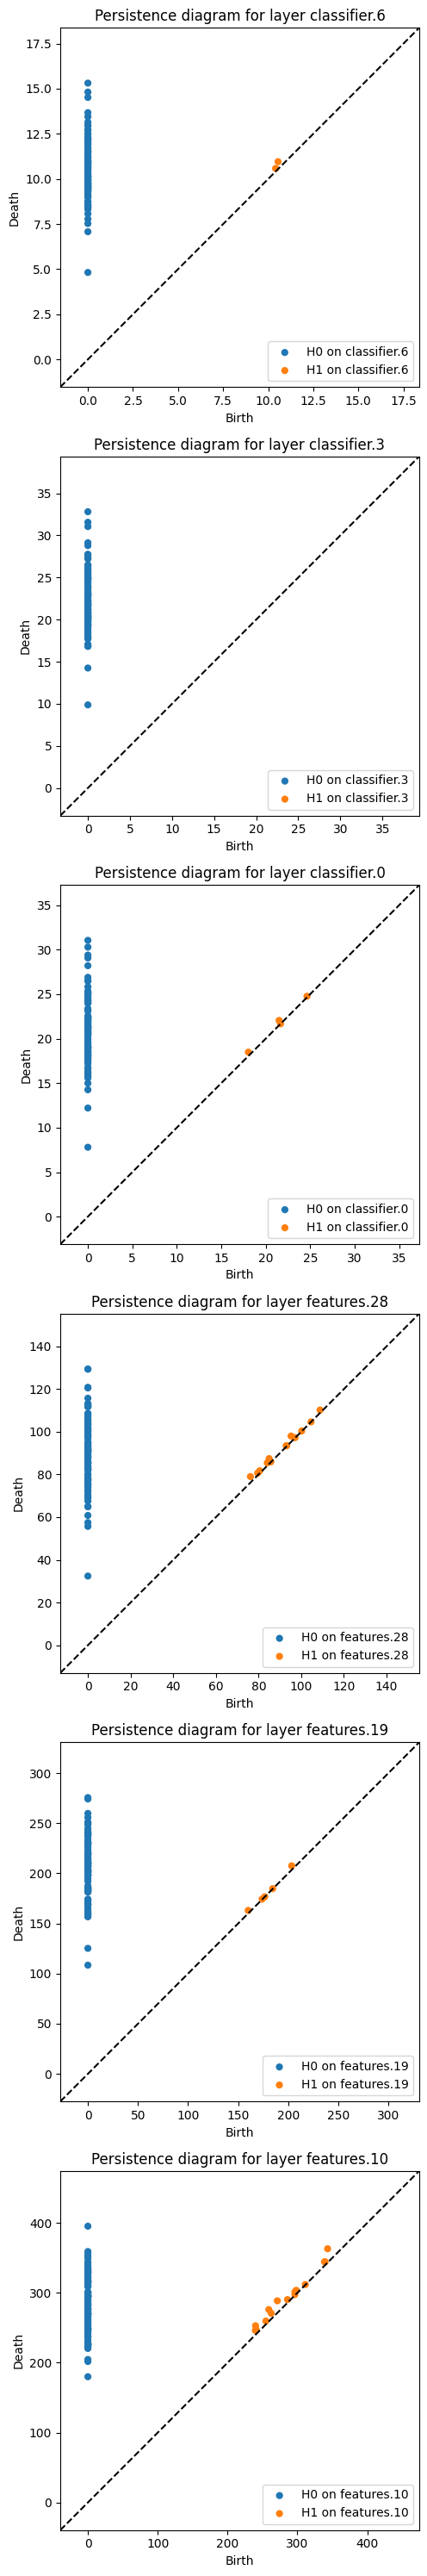

In [ ]:
num_diagrams = 6  # Number of diagrams to plot
fig, axes = plt.subplots(num_diagrams, 1, figsize=(10, num_diagrams * 5))

for i in range(num_diagrams):
    ax = axes[i]
    persim.plot_diagrams(vrs[-(i+1)], labels=[f'H0 on {layers[-(i+1)]}', f'H1 on {layers[-(i+1)]}'], size=35, ax=ax)
    ax.set_title(f'Persistence diagram for layer {layers[-(i+1)]}')

plt.tight_layout()
plt.show()

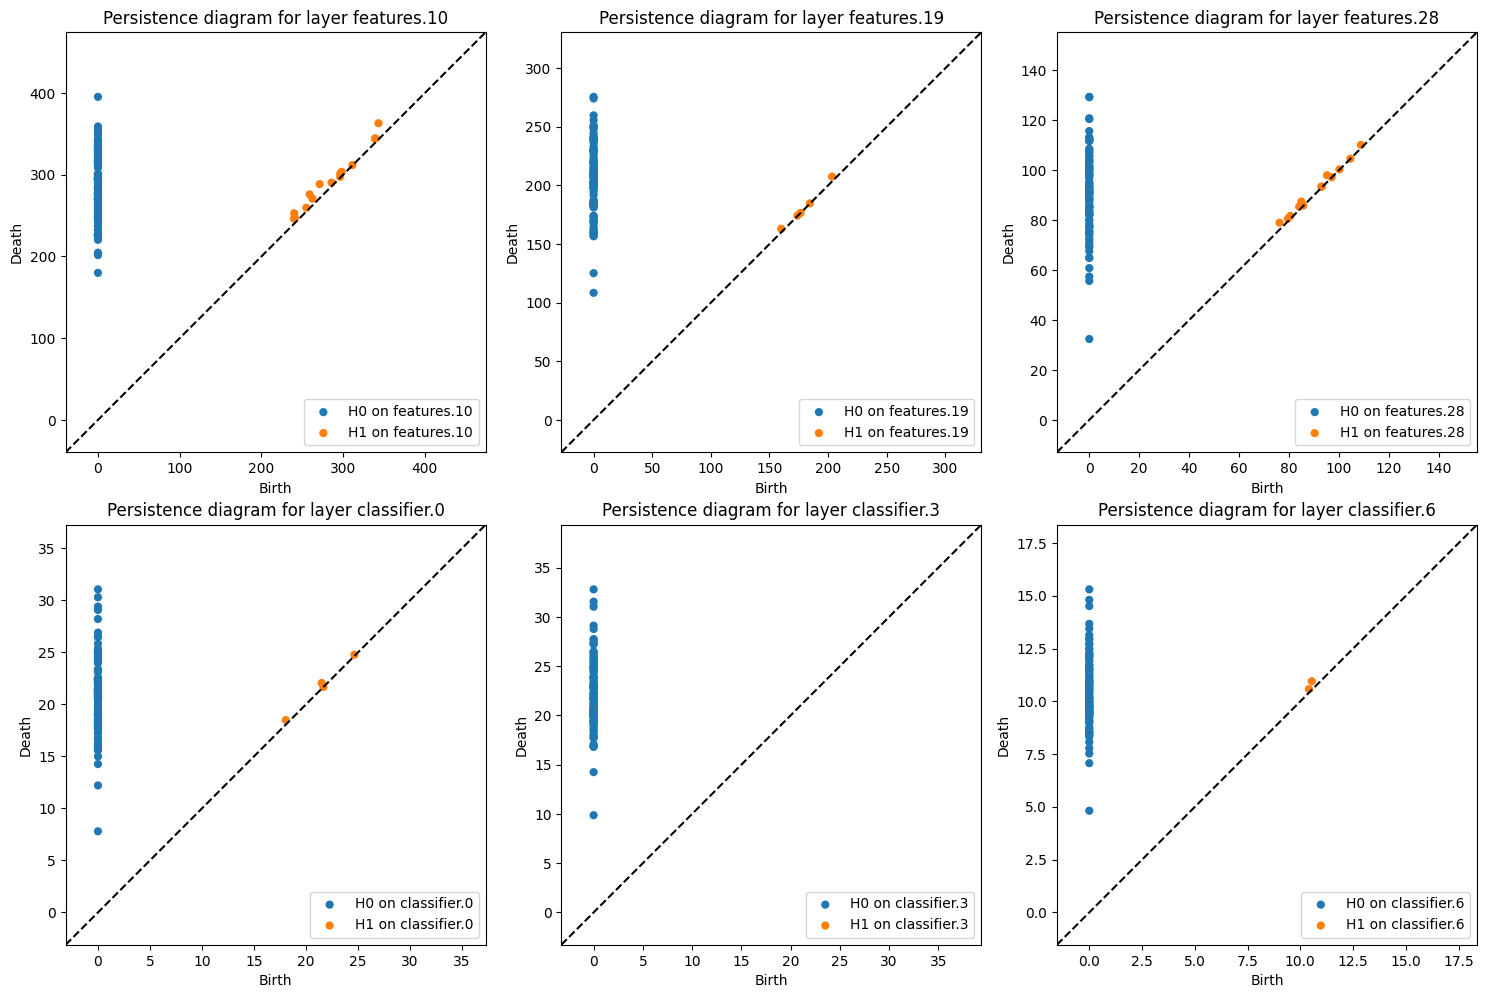

In [ ]:
num_diagrams = 6  # Number of diagrams to plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each persistence diagram in a subplot
for i in range(num_diagrams):
    ax = axes[i]
    persim.plot_diagrams(vrs[-(num_diagrams-i)], labels=[f'H0 on {layers[-(num_diagrams-i)]}', f'H1 on {layers[-(num_diagrams-i)]}'], size=35, ax=ax)
    ax.set_title(f'Persistence diagram for layer {layers[-(num_diagrams-i)]}')

# Hide any empty subplots (if fewer than 6 diagrams)
for j in range(num_diagrams, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


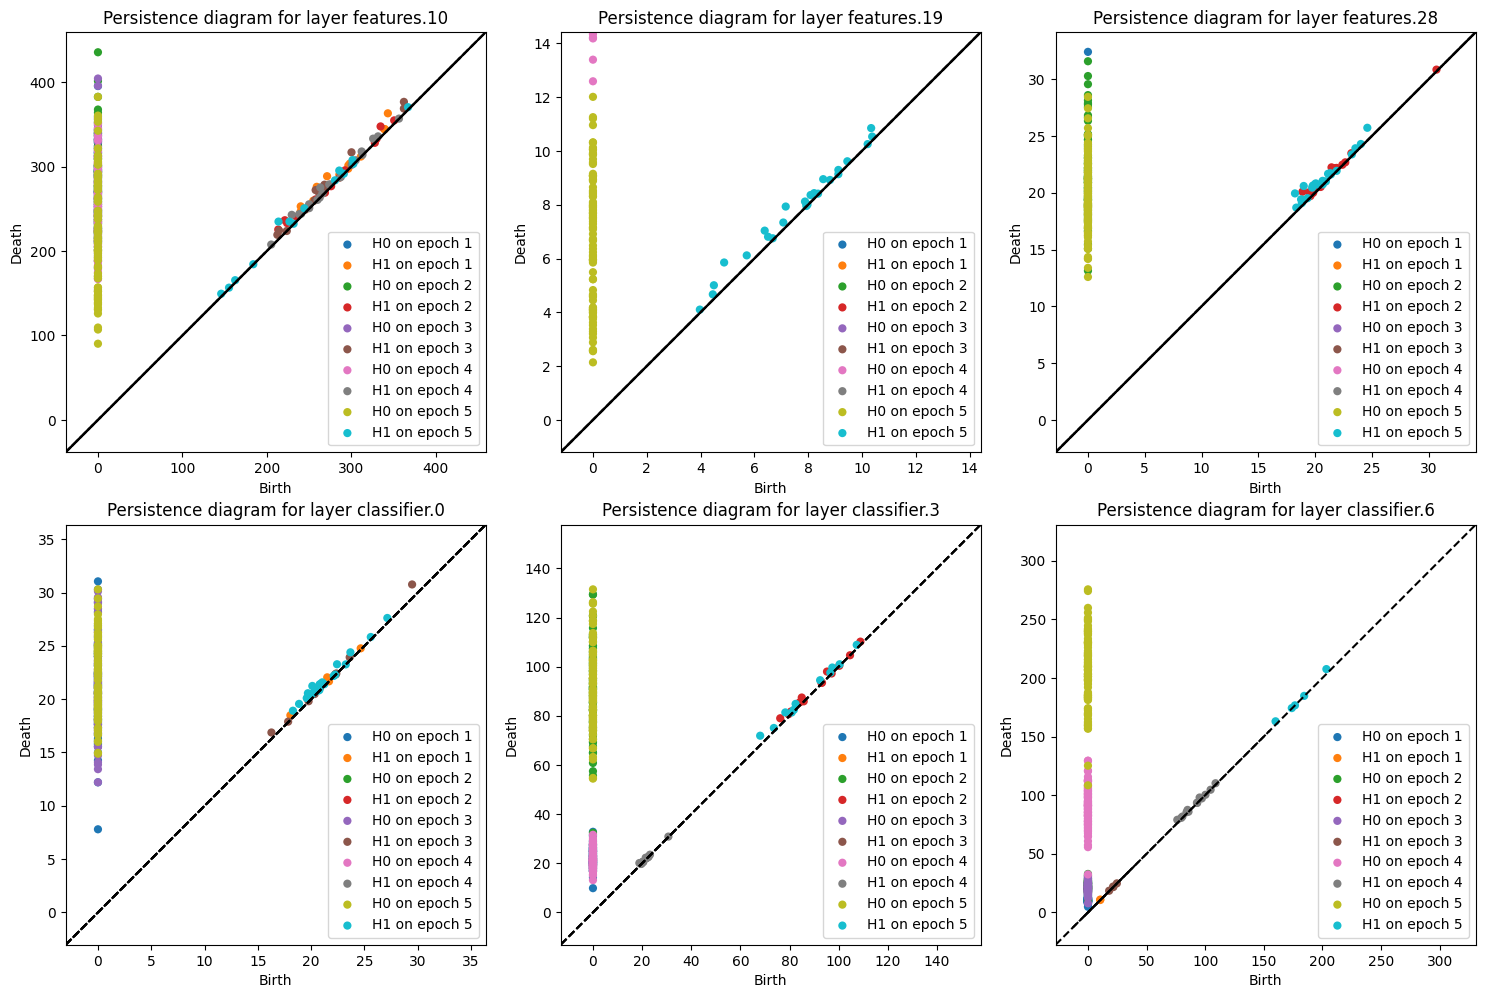

In [ ]:
num_diagrams = 6  # Number of diagrams to plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each persistence diagram in a subplot
for i in range(num_diagrams):
    ax = axes[i]
    for epoch in range(1,6):
      persim.plot_diagrams(vrs[-epoch*(num_diagrams-i)], labels=[f'H0 on epoch {epoch}', f'H1 on epoch {epoch}'], size=35, ax=ax)
      ax.set_title(f'Persistence diagram for layer {layers[-(num_diagrams-i)]}')

# Hide any empty subplots (if fewer than 6 diagrams)
for j in range(num_diagrams, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Total persistence

In [ ]:
def total_persistence_experiment(vrs, q):
  total_persistences = []
  for num_emb in range(len(vrs)):
    total_persistences.append(total_persistence(vrs[num_emb], q))
    print(f'Epoch: {list_epochs[num_emb]} | Layer: {list_layers[num_emb]} | Total persistence: {total_persistences[num_emb]}')
  return total_persistences

In [ ]:
total_p_half = total_persistence_experiment(vrs, q=0.5)

Epoch: 1 | Layer: features.10 | Total persistence: 1427.2210693359375
Epoch: 1 | Layer: features.19 | Total persistence: 1127.218994140625
Epoch: 1 | Layer: features.28 | Total persistence: 822.9397583007812
Epoch: 1 | Layer: classifier.0 | Total persistence: 377.4547119140625
Epoch: 1 | Layer: classifier.3 | Total persistence: 371.3730773925781
Epoch: 1 | Layer: classifier.6 | Total persistence: 254.11888122558594
Epoch: 2 | Layer: features.10 | Total persistence: 1556.19873046875
Epoch: 2 | Layer: features.19 | Total persistence: 1318.964111328125
Epoch: 2 | Layer: features.28 | Total persistence: 961.7373657226562
Epoch: 2 | Layer: classifier.0 | Total persistence: 445.9705810546875
Epoch: 2 | Layer: classifier.3 | Total persistence: 434.7025146484375
Epoch: 2 | Layer: classifier.6 | Total persistence: 296.952392578125
Epoch: 3 | Layer: features.10 | Total persistence: 1572.4962158203125
Epoch: 3 | Layer: features.19 | Total persistence: 1328.4757080078125
Epoch: 3 | Layer: features

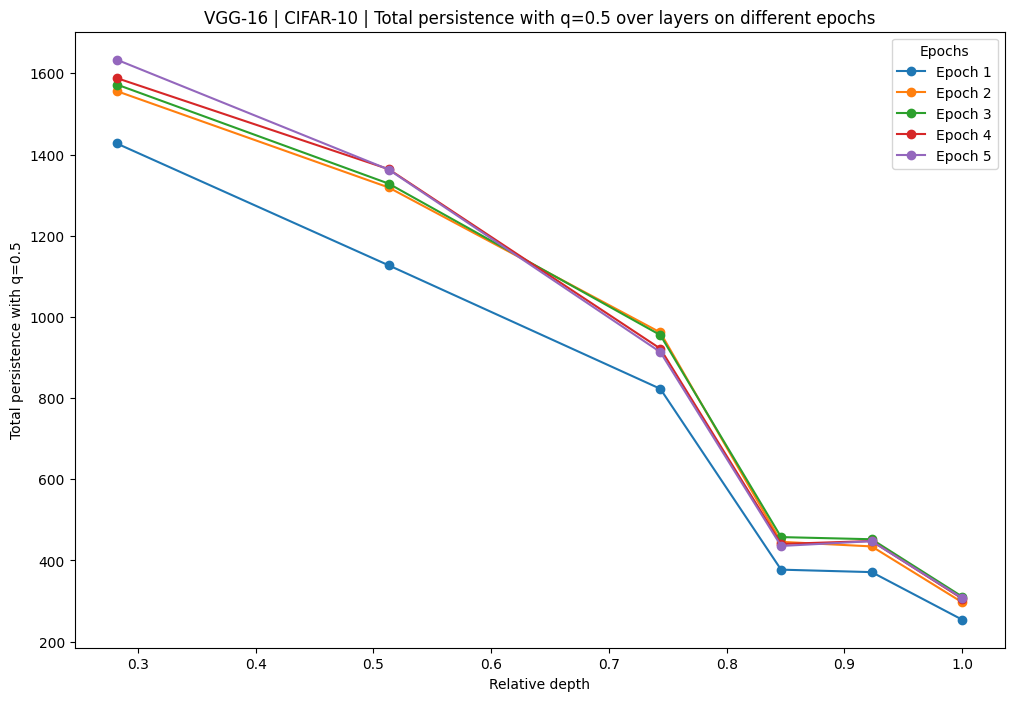

In [ ]:
plot_feature('Total persistence with q=0.5', total_p_half, 5, layers[-6:], list_relative_depths)

In [ ]:
total_p_full = total_persistence_experiment(vrs, q=1)

Epoch: 1 | Layer: features.10 | Total persistence: 21182.111328125
Epoch: 1 | Layer: features.19 | Total persistence: 13633.7685546875
Epoch: 1 | Layer: features.28 | Total persistence: 7248.38720703125
Epoch: 1 | Layer: classifier.0 | Total persistence: 1483.3203125
Epoch: 1 | Layer: classifier.3 | Total persistence: 1389.1295166015625
Epoch: 1 | Layer: classifier.6 | Total persistence: 648.629638671875
Epoch: 2 | Layer: features.10 | Total persistence: 24679.271484375
Epoch: 2 | Layer: features.19 | Total persistence: 18046.55078125
Epoch: 2 | Layer: features.28 | Total persistence: 9327.9599609375
Epoch: 2 | Layer: classifier.0 | Total persistence: 1995.9251708984375
Epoch: 2 | Layer: classifier.3 | Total persistence: 1873.3055419921875
Epoch: 2 | Layer: classifier.6 | Total persistence: 873.155517578125
Epoch: 3 | Layer: features.10 | Total persistence: 25130.6171875
Epoch: 3 | Layer: features.19 | Total persistence: 18626.046875
Epoch: 3 | Layer: features.28 | Total persistence: 9

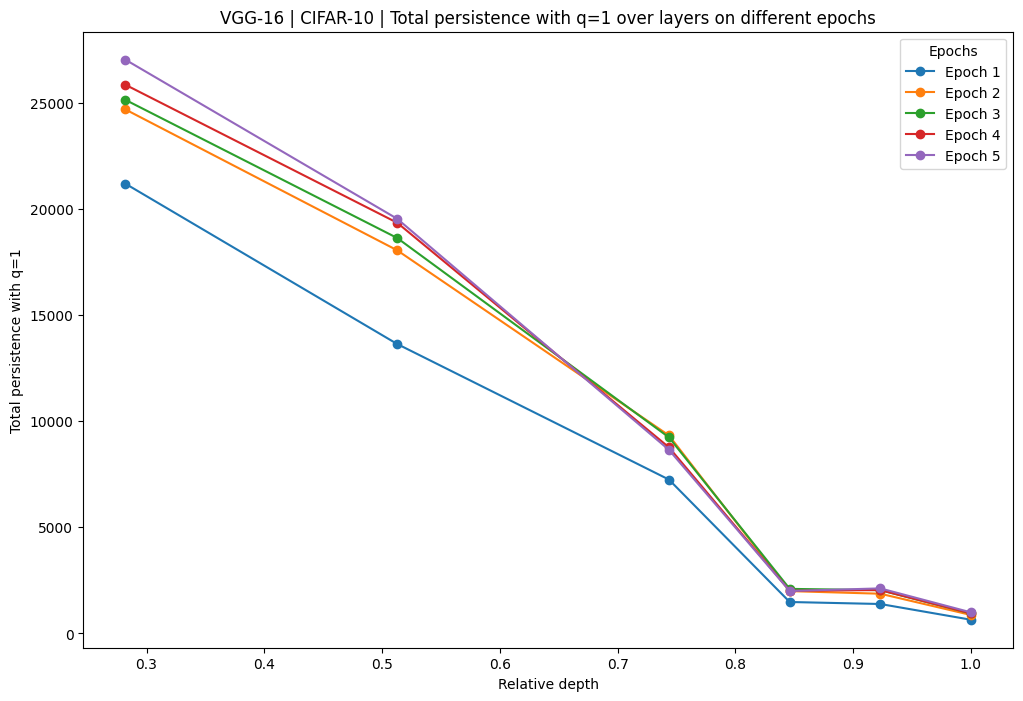

In [ ]:
plot_feature('Total persistence with q=1', total_p_full, 5, layers[-6:], list_relative_depths)

### Persistence entropy

In [ ]:
from intrinsic.functional.homology import persistence_entropy

In [ ]:
def persistence_entropy_experiment(vrs):
  persistence_entropies = []
  for num_emb in range(len(vrs)):
    persistence_entropies.append(persistence_entropy(vrs[num_emb]))
    print(f'Epoch: {list_epochs[num_emb]} | Layer: {list_layers[num_emb]} | Persistent entropy: {persistence_entropies[num_emb]}')
  return persistence_entropies

In [ ]:
persistent_entropies = persistence_entropy_experiment(vrs)

Epoch: 1 | Layer: features.10 | Persistent entropy: [4.504572  2.2846606]
Epoch: 1 | Layer: features.19 | Persistent entropy: [4.460248  1.8796113]
Epoch: 1 | Layer: features.28 | Persistent entropy: [4.4367137 2.6463563]
Epoch: 1 | Layer: classifier.0 | Persistent entropy: [4.4603105 2.8042254]
Epoch: 1 | Layer: classifier.3 | Persistent entropy: [4.481237  2.8926542]
Epoch: 1 | Layer: classifier.6 | Persistent entropy: [4.492232  3.4628391]
Epoch: 2 | Layer: features.10 | Persistent entropy: [4.537895  2.3346658]
Epoch: 2 | Layer: features.19 | Persistent entropy: [4.537833 1.923504]
Epoch: 2 | Layer: features.28 | Persistent entropy: [4.5353804 2.8043272]
Epoch: 2 | Layer: classifier.0 | Persistent entropy: [4.5373144 2.7537122]
Epoch: 2 | Layer: classifier.3 | Persistent entropy: [4.5400195 2.9076195]
Epoch: 2 | Layer: classifier.6 | Persistent entropy: [4.5343776 3.1999612]
Epoch: 3 | Layer: features.10 | Persistent entropy: [4.5327506 2.5553098]
Epoch: 3 | Layer: features.19 | Pe

In [ ]:
persistent_entropies

[array([4.504572 , 2.2846606], dtype=float32),
 array([4.460248 , 1.8796113], dtype=float32),
 array([4.4367137, 2.6463563], dtype=float32),
 array([4.4603105, 2.8042254], dtype=float32),
 array([4.481237 , 2.8926542], dtype=float32),
 array([4.492232 , 3.4628391], dtype=float32),
 array([4.537895 , 2.3346658], dtype=float32),
 array([4.537833, 1.923504], dtype=float32),
 array([4.5353804, 2.8043272], dtype=float32),
 array([4.5373144, 2.7537122], dtype=float32),
 array([4.5400195, 2.9076195], dtype=float32),
 array([4.5343776, 3.1999612], dtype=float32),
 array([4.5327506, 2.5553098], dtype=float32),
 array([4.535894, 0.644223], dtype=float32),
 array([4.538108, 2.711575], dtype=float32),
 array([4.5404043, 2.786633 ], dtype=float32),
 array([4.5438466, 2.9009423], dtype=float32),
 array([4.537327 , 3.3082986], dtype=float32),
 array([4.537048, 2.277409], dtype=float32),
 array([4.5398555, 1.6401576], dtype=float32),
 array([4.5371976, 2.4413803], dtype=float32),
 array([4.536137, 2.1